In [5]:
import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm

%matplotlib inline

In [6]:
from Master_Functions import CondExtBivNegLogLik
from dlaplace import deltaL

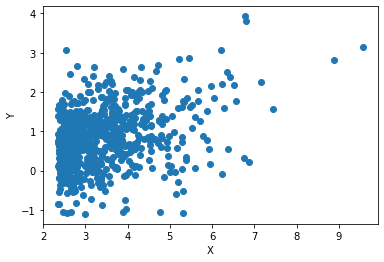

In [7]:
# Create toy data. We require X to be Laplace. 
X = laplace(0,1).rvs(15000)

#We'll also let Z be Gaussian noise, albeit not standard

#Condition on X being larger than some high quantile u

u = np.quantile(X,0.95)
X = X[X>u]
Z = np.random.normal(loc = 0.2,scale = 0.3,size=len(X))

Y = 0.1 * X + Z*(X**0.7)


fig=plt.figure()
plt.scatter(X,Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [11]:
## Fit distribution. We will use Delta-Laplace margins.

init_par=np.random.rand(5)

X_data, Y_data = X,Y

fit = minimize(fun = CondExtBivNegLogLik,x0 = init_par, args=(X_data,Y_data,True,[0,1]),
               method="Nelder-Mead")
fit

 final_simplex: (array([[0.23648711, 0.50904056, 0.02140077, 0.50095893, 1.79840317],
       [0.23649048, 0.50908077, 0.02138813, 0.50093918, 1.79843754],
       [0.23649422, 0.50908122, 0.02138259, 0.50092689, 1.79836455],
       [0.23649923, 0.50905034, 0.0213724 , 0.50096006, 1.79841731],
       [0.23653415, 0.50905387, 0.02131589, 0.50095685, 1.7984455 ],
       [0.23651364, 0.50895973, 0.0213501 , 0.50101252, 1.79843474]]), array([778.68868469, 778.68868473, 778.68868477, 778.68868483,
       778.68868489, 778.68868489]))
           fun: 778.6886846948526
       message: 'Optimization terminated successfully.'
          nfev: 687
           nit: 428
        status: 0
       success: True
             x: array([0.23648711, 0.50904056, 0.02140077, 0.50095893, 1.79840317])

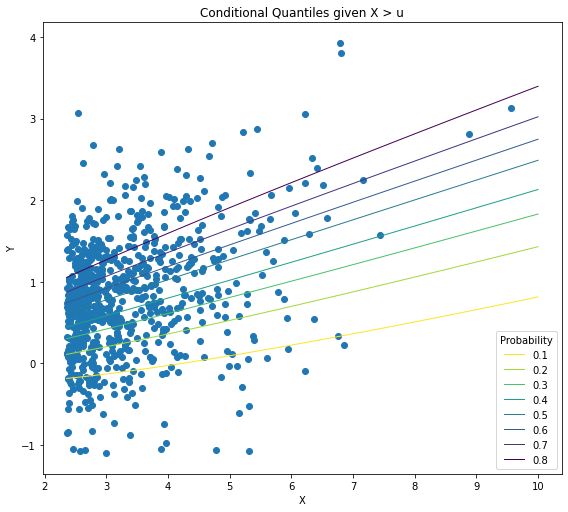

In [12]:
# Overlay conditional quantiles, given X > u, on Scatter plot
alpha,beta,mu,sigma,delta = fit.x

x_seq=np.linspace(u,10,100)
probs=np.arange(0.1,0.9,0.1)

#Quantiles from the data. 
z_hat = (Y - alpha * X)/ X** beta

quants = np.quantile(z_hat, probs)

plt.figure(figsize=(8,7))
plt.scatter(X,Y)
viridis = cm.get_cmap('viridis', len(probs))
for k in range(0,len(probs)):
    
    plt.plot(x_seq,alpha*x_seq+quants[k]*x_seq**beta,color = viridis.colors[-(k+1)], linewidth = 1)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend( np.around(probs,2), loc = 4, title = "Probability")
plt.tight_layout()
plt.title("Conditional Quantiles given X > u")
plt.show()
